In [1]:
import numpy as np
import pandas as pd
import math
import time
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.ndimage as ndimage
import matplotlib.gridspec as gridspec

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import lightgbm as lgb

import torch
import torch.nn as nn
import torch.nn.functional as F
from skorch import NeuralNetRegressor
from skorch.callbacks import EarlyStopping, EpochScoring

In [2]:
CUBE_PATH = "../sdss_cube_sfr/SDSS_cube_lean.h5"
sfrs = pd.read_hdf(CUBE_PATH, key="fits_spectra_metadata_star_formation_rates")
with h5py.File(CUBE_PATH, "r") as cube:
    metadata = cube["dense_cube/0/ml_spectrum/spec_metadata_refs"][:]
metadata_indices = metadata[:, 0]["ds_slice_idx"]

# Data exploration and processing:

In [3]:
sfrs = sfrs[sfrs.index.isin(metadata_indices)].copy()
sfrs = sfrs[sfrs["AVG"].notna()].copy()
sfrs_filtered = sfrs[sfrs["AVG"] >= -80].copy()
sfrs_flag0_filtered = sfrs_filtered[sfrs_filtered["FLAG"] == 0.0].copy()
sfrs_flag_not0_filtered = sfrs_filtered[sfrs_filtered["FLAG"] != 0.0].copy()

print("Total records in sfrs (before filtering by image/spectrum):", len(sfrs))
print("Total records after filtering by image/spectrum availability:", len(sfrs))
print("Total records after removing NaN in AVG:", len(sfrs))
print("Total records after filtering AVG >= -80:", len(sfrs_filtered))
print("Among them, FLAG == 0:", len(sfrs_flag0_filtered))
print("Among them, FLAG != 0:", len(sfrs_flag_not0_filtered))

sfrs_flag0 = sfrs[sfrs["FLAG"] == 0.0]
labels_pie = ["FLAG == 0", "FLAG != 0"]
sizes = [len(sfrs_flag0), len(sfrs) - len(sfrs_flag0)]

Total records in sfrs (before filtering by image/spectrum): 34613
Total records after filtering by image/spectrum availability: 34613
Total records after removing NaN in AVG: 34613
Total records after filtering AVG >= -80: 30752
Among them, FLAG == 0: 16841
Among them, FLAG != 0: 13911


In [4]:
mask_all = np.in1d(metadata_indices, sfrs_filtered.index)
mask_flag0 = np.in1d(metadata_indices, sfrs_flag0_filtered.index)
selected_all = metadata_indices[mask_all]
selected_flag0 = metadata_indices[mask_flag0]

all_images = []
all_spectra = []
filtered_images = []
filtered_spectra = []

for zoom in range(4):
    img_key = f"dense_cube/{zoom}/ml_image/cutout_3d_cube_zoom_{zoom}"
    spec_key = f"dense_cube/{zoom}/ml_spectrum/spectral_1d_cube_zoom_{zoom}"
    with h5py.File(CUBE_PATH, "r") as cube:
        images_zoom = cube[img_key][:][mask_all]
        spectra_zoom = cube[spec_key][:][mask_all]
    all_images.append(images_zoom)
    all_spectra.append(spectra_zoom)
    with h5py.File(CUBE_PATH, "r") as cube:
        images_zoom_flag0 = cube[img_key][:][mask_flag0]
        spectra_zoom_flag0 = cube[spec_key][:][mask_flag0]
    filtered_images.append(images_zoom_flag0)
    filtered_spectra.append(spectra_zoom_flag0)

print("All images shape (zoom 0):", all_images[0].shape)
print("Filtered images shape (zoom 0):", filtered_images[0].shape)
print("All spectra shape (zoom 0):", all_spectra[0].shape)
print("Filtered spectra shape (zoom 0):", filtered_spectra[0].shape)

All images shape (zoom 0): (30752, 5, 64, 64)
Filtered images shape (zoom 0): (16841, 5, 64, 64)
All spectra shape (zoom 0): (30752, 4620)
Filtered spectra shape (zoom 0): (16841, 4620)


In [5]:
nan_counts_all = np.sum(np.isnan(all_spectra[0]), axis=1)
nan_counts_flag0 = np.sum(np.isnan(filtered_spectra[0]), axis=1)
total_length = all_spectra[0].shape[1]

In [6]:
total_length = all_spectra[0].shape[1]
wavelengths = np.linspace(3800, 9200, total_length)

fraction_nan_all = np.mean(np.isnan(all_spectra[0]), axis=0)
fraction_nan_flag0 = np.mean(np.isnan(filtered_spectra[0]), axis=0)

### Delete all the spectra that contain nan:

In [7]:
mask_clean_all = ~np.isnan(all_spectra[0]).any(axis=1)
mask_clean_flag0 = ~np.isnan(filtered_spectra[0]).any(axis=1)

cleaned_all_images = [arr[mask_clean_all] for arr in all_images]
cleaned_all_spectra = [arr[mask_clean_all] for arr in all_spectra]

cleaned_filtered_images = [arr[mask_clean_flag0] for arr in filtered_images]
cleaned_filtered_spectra = [arr[mask_clean_flag0] for arr in filtered_spectra]

selected_all_clean = selected_all[mask_clean_all]
selected_flag0_clean = selected_flag0[mask_clean_flag0]

cleaned_sfrs_all = sfrs_filtered.loc[selected_all_clean]
cleaned_sfrs_flag0 = sfrs_flag0_filtered.loc[selected_flag0_clean]

print("Cleaned All spectra shape (zoom 0):", cleaned_all_spectra[0].shape)
print("Cleaned FLAG==0 spectra shape (zoom 0):", cleaned_filtered_spectra[0].shape)
print("Spectra removed (all):", all_spectra[0].shape[0] - cleaned_all_spectra[0].shape[0])
print("Spectra removed (FLAG==0):", filtered_spectra[0].shape[0] - cleaned_filtered_spectra[0].shape[0])

print("\nCleaned All images shape (zoom 0):", cleaned_all_images[0].shape)
print("Cleaned FLAG==0 images shape (zoom 0):", cleaned_filtered_images[0].shape)
print("Images removed (all):", all_images[0].shape[0] - cleaned_all_images[0].shape[0])
print("Images removed (FLAG==0):", filtered_images[0].shape[0] - cleaned_filtered_images[0].shape[0])

print("\nCleaned SFR (all) shape:", cleaned_sfrs_all.shape)
print("Cleaned SFR (FLAG==0) shape:", cleaned_sfrs_flag0.shape)
print("SFR records removed (all):", sfrs_filtered.shape[0] - cleaned_sfrs_all.shape[0])
print("SFR records removed (FLAG==0):", sfrs_flag0_filtered.shape[0] - cleaned_sfrs_flag0.shape[0])


Cleaned All spectra shape (zoom 0): (20157, 4620)
Cleaned FLAG==0 spectra shape (zoom 0): (11179, 4620)
Spectra removed (all): 10595
Spectra removed (FLAG==0): 5662

Cleaned All images shape (zoom 0): (20157, 5, 64, 64)
Cleaned FLAG==0 images shape (zoom 0): (11179, 5, 64, 64)
Images removed (all): 10595
Images removed (FLAG==0): 5662

Cleaned SFR (all) shape: (20157, 284)
Cleaned SFR (FLAG==0) shape: (11179, 284)
SFR records removed (all): 10595
SFR records removed (FLAG==0): 5662


In [8]:
def normalize_images(images_list):
    normalized_list = []
    for img_array in images_list:
        min_val = np.min(img_array, axis=(2,3), keepdims=True)
        max_val = np.max(img_array, axis=(2,3), keepdims=True)
        norm_img = 2 * (img_array - min_val) / (max_val - min_val) - 1
        normalized_list.append(norm_img)
    return normalized_list

normalized_all_images = normalize_images(cleaned_all_images)
normalized_filtered_images = normalize_images(cleaned_filtered_images)

In [9]:
labels_flag0 = sfrs_flag0_filtered.loc[:, "TARGETTYPE"]
labels_flag_not0 = sfrs_filtered.loc[sfrs_filtered["FLAG"] != 0.0, "TARGETTYPE"]

def simplify_targettype(val):
    if isinstance(val, bytes):
        val = val.decode("utf-8").strip()
    else:
        val = str(val).strip()
    if "GALAXY" in val:
        return "GALAXY"
    elif "QSO" in val or "QA" in val:
        return "QUASAR"
    elif "STAR" in val:
        return "STAR"
    else:
        return "OTHER"

df_flag0_orig = pd.DataFrame({"TARGETTYPE": labels_flag0})
df_flag_not0_orig = pd.DataFrame({"TARGETTYPE": labels_flag_not0})

df_flag0_simpl = pd.DataFrame({"Simplified_TARGETTYPE": pd.Series(labels_flag0).apply(simplify_targettype)})
df_flag_not0_simpl = pd.DataFrame({"Simplified_TARGETTYPE": pd.Series(labels_flag_not0).apply(simplify_targettype)})

In [10]:
def normalize_spectra(spectra_list):
    normalized_list = []
    for spec in spectra_list:
        if spec.ndim == 1:
            spec = spec[np.newaxis, :]
        min_val = np.nanmin(spec, axis=1, keepdims=True)
        max_val = np.nanmax(spec, axis=1, keepdims=True)
        diff = np.where((max_val - min_val)==0, 1, max_val - min_val)
        norm_spec = 2 * (spec - min_val) / diff - 1
        normalized_list.append(norm_spec)
    result = np.empty(len(normalized_list), dtype=object)
    for i, arr in enumerate(normalized_list):
        result[i] = arr
    return result

normalized_all_spectra = normalize_spectra(cleaned_all_spectra)
normalized_filtered_spectra = normalize_spectra(cleaned_filtered_spectra)

## Getting rid of photos with multiple objects:

In [11]:
flag0_indices = cleaned_sfrs_flag0.index
all_indices = cleaned_sfrs_all.index
flag_not0_indices = all_indices.difference(flag0_indices)
mask_flag_not0 = np.isin(cleaned_sfrs_all.index, flag_not0_indices)
normalized_nonflag0_images = [arr[mask_flag_not0] for arr in normalized_all_images]

In [12]:
CROP_SIZES_4 = {
    0: 32,  # originally 64
    1: 16,  # originally 32
    2: 8,   # originally 16
    3: 4    # originally 8
}
THRESHOLD = 0.9

def detect_and_visualize_multiple_objects(images_list, thresholds, crop_sizes=None, max_objects=1, thumbnail_size=3, group_name="", print_spectra=False, spectra_list=None):
    images_trimmed = []
    for i, img_array in enumerate(images_list):
        original_size = img_array.shape[-1]
        target_size = crop_sizes.get(i, original_size) if crop_sizes is not None else original_size
        start = (original_size - target_size) // 2
        end = start + target_size
        trimmed = img_array[..., start:end, start:end]
        images_trimmed.append(trimmed)
    multi_obj_indices = []
    for idx in range(images_trimmed[0].shape[0]):
        image = images_trimmed[0][idx, 2, :, :]
        image_normalized = (image + 1) / 2
        binary = image_normalized > thresholds
        labeled, num_features = ndimage.label(binary)
        if num_features > 1:
            multi_obj_indices.append(idx)
    total_images = images_trimmed[0].shape[0]
    count_multi = len(multi_obj_indices)
    percent_multi = (count_multi / total_images)*100 if total_images>0 else 0
    print(f"{group_name}: Found {count_multi} images with multiple objects from {total_images} ({percent_multi:.2f}%).")
    if multi_obj_indices:
        display_indices = multi_obj_indices[:max_objects]
        if print_spectra and spectra_list is not None:
            num_disp = len(display_indices)
            fig = plt.figure(figsize=(15, thumbnail_size * 2 * num_disp), dpi=100)
            gs = gridspec.GridSpec(2 * num_disp, 5, hspace=0.6, wspace=0.3)
            for i, obj_idx in enumerate(display_indices):
                for col in range(5):
                    ax = fig.add_subplot(gs[2*i, col])
                    img_data = images_trimmed[0][obj_idx, col, :, :]
                    ax.imshow(img_data, vmin=-1, vmax=1)
                    ax.set_title(f"Filter {col}", fontsize=10)
                    ax.axis("off")
                ax_spec = fig.add_subplot(gs[2*i+1, :])
                spectrum = spectra_list[0][obj_idx]
                wavelengths = np.linspace(3800,9200, len(spectrum))
                ax_spec.plot(wavelengths, spectrum, color="blue", linewidth=0.3)
                ax_spec.set_title("Spectrum (Zoom 0)", fontsize=10)
                ax_spec.set_xlabel("Wavelength (Å)", fontsize=10)
                ax_spec.set_ylabel("Flux", fontsize=10)
                ax_spec.set_xlim([3800,9200])
                ax_spec.set_ylim([-1,1])
            fig.suptitle(f"Images with ≥2 objects and spectra ({group_name})", fontsize=14)
            fig.tight_layout()
            fig.subplots_adjust(top=0.93)
            plt.show()
        else:
            num_disp = len(display_indices)
            fig, axes = plt.subplots(num_disp, 5, figsize=(15, thumbnail_size * num_disp), dpi=100)
            if num_disp == 1:
                axes = axes.reshape(1, -1)
            for row, obj_idx in enumerate(display_indices):
                for col in range(5):
                    ax = axes[row, col]
                    img_data = images_trimmed[0][obj_idx, col, :, :]
                    ax.imshow(img_data, vmin=-1, vmax=1)
                    ax.set_title(f"Filter {col}", fontsize=10)
                    ax.axis("off")
            fig.suptitle(f"Images with ≥2 objects ({group_name})", fontsize=14)
            fig.tight_layout()
            fig.subplots_adjust(top=0.99)
            plt.show()
    else:
        print(f"No images found for {group_name} with multiple objects.")
    return images_trimmed, multi_obj_indices

FLAG != 0 (Original): Found 1184 images with multiple objects from 8978 (13.19%).


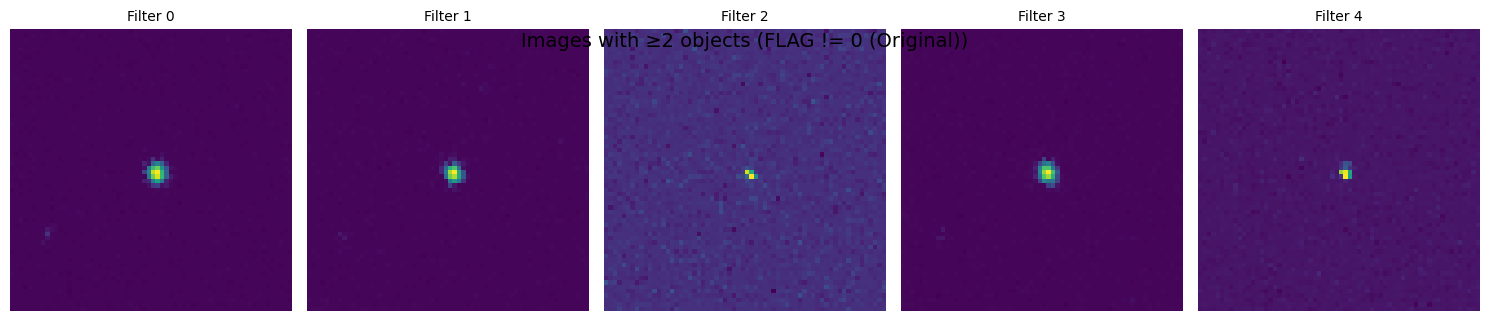

In [13]:
orig_images_flag_not0, multi_obj_indices_flag_not0 = detect_and_visualize_multiple_objects(normalized_nonflag0_images, thresholds=THRESHOLD, crop_sizes=None, group_name="FLAG != 0 (Original)", print_spectra=False, spectra_list=normalized_filtered_spectra)

FLAG == 0 (Original): Found 1111 images with multiple objects from 11179 (9.94%).


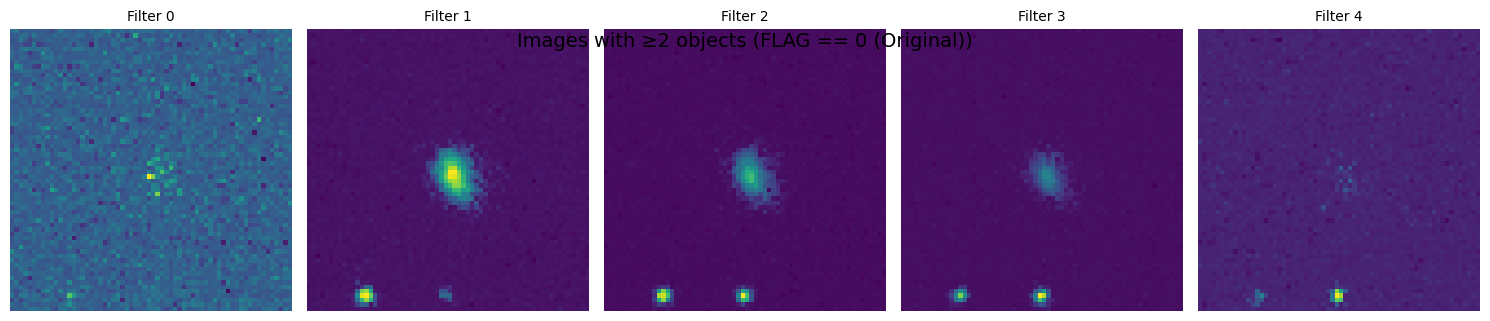

In [14]:
orig_images_flag0, multi_obj_indices_flag0 = detect_and_visualize_multiple_objects(normalized_filtered_images, thresholds=THRESHOLD, crop_sizes=None, group_name="FLAG == 0 (Original)", print_spectra=False, spectra_list=normalized_filtered_spectra)

# Machine Learning (FLAG == 0 only):

## VGGNet12:

In [15]:
class CustomMSELoss(nn.Module):
    def __init__(self):
        super(CustomMSELoss, self).__init__()
    def forward(self, output, target):
        if target.dim() == 1:
            target = target.view(-1, 1)
        return F.mse_loss(output, target)

class VGGNet12(nn.Module):
    def __init__(self, input_channels, input_height, input_width, dropout=0.5):
        super(VGGNet12, self).__init__()
        # Use different pooling if height==1
        if input_height == 1:
            pool1 = nn.MaxPool2d(kernel_size=(1,2), stride=(1,2))
            pool2 = nn.MaxPool2d(kernel_size=(1,2), stride=(1,2))
        else:
            pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
            pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Block 1
        self.block1 = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            pool1
        )
        # Block 2
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            pool2
        )
        # Block 3
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        # Adaptive pooling to ensure non-zero output size
        pool_h = max(1, input_height // 8)
        pool_w = max(1, input_width // 8)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((pool_h, pool_w))
        fc_input_dim = 256 * pool_h * pool_w
        self.fc1 = nn.Linear(fc_input_dim, 512)
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(512, 128)
        self.dropout2 = nn.Dropout(dropout)
        self.fc3 = nn.Linear(128, 1)
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

In [16]:
def run_skorch_grid_search_vgg(X, Y, param_grid, input_channels, input_height, input_width):
    net = NeuralNetRegressor(
        module=VGGNet12,
        module__input_channels=input_channels,
        module__input_height=input_height,
        module__input_width=input_width,
        module__dropout=0.5,
        max_epochs=50,
        lr=0.001,
        optimizer=torch.optim.Adam,
        batch_size=32,
        iterator_train__shuffle=True,
        callbacks=[('early_stopping', EarlyStopping(patience=5))],
        device='cuda' if torch.cuda.is_available() else 'cpu',
        criterion=CustomMSELoss,
    )
    gs = GridSearchCV(net, param_grid, scoring='r2', cv=3)
    gs.fit(X, Y)
    best_score = gs.best_score_
    best_params = gs.best_params_
    best_model = gs.best_estimator_
    Y_pred = best_model.predict(X)
    mae = mean_absolute_error(Y, Y_pred)
    r2_val = r2_score(Y, Y_pred)
    error = Y_pred - Y
    nmad = 1.4826 * np.median(np.abs(error - np.median(error)))
    rmse = np.sqrt(mean_squared_error(Y, Y_pred))
    return best_score, best_params, mae, r2_val, nmad, rmse, best_model

def plot_history(model, fusion_name, zoom_level):
    # Assumes model.history is available from skorch NeuralNetRegressor
    train_losses = model.history[:, 'train_loss']
    val_losses = model.history[:, 'valid_loss']
    plt.figure(figsize=(8,5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{fusion_name} - Training & Validation Loss (Zoom {zoom_level})')
    plt.legend()
    plt.grid()
    plt.show()

param_grid_vgg = {
    'lr': [0.001, 0.0001, 0.00001],
    'module__dropout': [0.5],
    'callbacks__early_stopping__patience': [10]
}

In [17]:
selected_Y_flag0 = cleaned_sfrs_flag0.loc[selected_flag0_clean]["AVG"].values
Y_all = selected_Y_flag0
results_vgg = {'Original Img': {}, 'Spectra': {}}

# Run grid search for zoom 0 on Original Img if not exists
if f'zoom_{0}' not in results_vgg['Original Img']:
    results_vgg['Original Img'][f'zoom_{0}'] = {'best_cv_score': 0, 'best_params': {}, 'mae': 0, 'r2': 0, 'nmad': 0, 'rmse': 0}
if f'zoom_{0}' not in results_vgg['Spectra']:
    results_vgg['Spectra'][f'zoom_{0}'] = {'best_cv_score': 0, 'best_params': {}, 'mae': 0, 'r2': 0, 'nmad': 0, 'rmse': 0}

photo_candidate = ("Original Img", 0, results_vgg['Original Img'][f'zoom_{0}']['mae'], orig_images_flag0[0])
spectra_candidate = ("Spectra", 0, results_vgg['Spectra'][f'zoom_{0}']['mae'], normalized_filtered_spectra[0])
print("Photo candidate:", photo_candidate[0], "zoom", photo_candidate[1])
print("Spectra candidate:", spectra_candidate[0], "zoom", spectra_candidate[1])

n_samples = min(photo_candidate[3].shape[0], spectra_candidate[3].shape[0], len(Y_all))
X_photo = photo_candidate[3][:n_samples]
X_spec = spectra_candidate[3][:n_samples]
Y = Y_all[:n_samples]
runtime = {}

Photo candidate: Original Img zoom 0
Spectra candidate: Spectra zoom 0


## Spectrum and Photo separately:

### VGGNet12 on Photo: 

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5267        0.5324  3.9684
      2        0.5241        0.5323  3.1463
      3        0.5240        0.5322  3.1401
      4        0.5235        0.5322  3.1449
      5        0.5238        0.5322  3.1364
      6        0.5232        0.5322  3.1365
      7        0.5237        0.5322  3.1444
      8        0.5238        0.5322  3.1415
      9        0.5233        0.5327  3.1245
     10        0.5237        0.5323  3.1170
     11        0.5232        0.5324  3.1225
     12        0.5234        0.5322  3.1350
Stopping since valid_loss has not improved in the last 10 epochs.
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5455        0.5708  3.1546
      2        0.5372        0.5713  3.1330
      3        0.5359        0.5686  3.1358
      4        0.5368        0.5714  3.1322
      5        0.5364        0.5755  3.1383
      6   

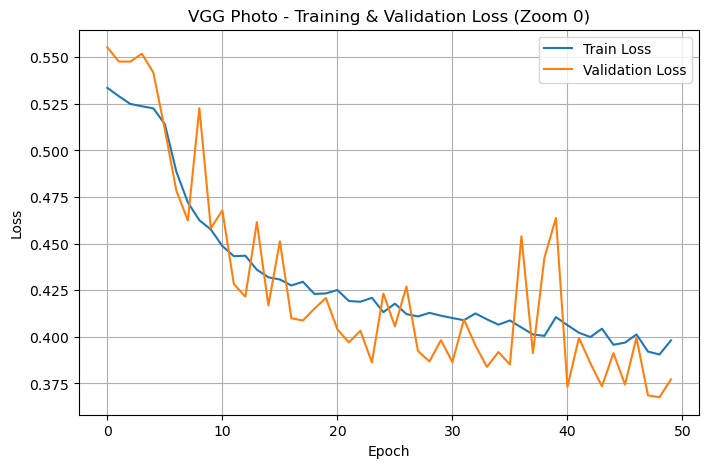

In [18]:
start = time.time()
vgg_photo_score, vgg_photo_params, vgg_photo_mae, vgg_photo_r2, vgg_photo_nmad, vgg_photo_rmse, vgg_photo_model = run_skorch_grid_search_vgg(
    X_photo, Y, param_grid_vgg, X_photo.shape[1], X_photo.shape[2], X_photo.shape[3]
)
vgg_photo = {'r2': vgg_photo_r2, 'mae': vgg_photo_mae, 'nmad': vgg_photo_nmad, 'rmse': vgg_photo_rmse}
runtime["VGG Photo"] = time.time() - start
print("VGG Photo best params:", vgg_photo_params)
plot_history(vgg_photo_model, "VGG Photo", 0)

### VGGNet12 on Spectra:

  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        0.5294        0.5345  19.4084
      2        0.5241        0.5323  19.3218
      3        0.5238        0.5322  19.3257
      4        0.5238        0.5322  19.3328
      5        0.5240        0.5324  19.3367
      6        0.5240        0.5322  19.3299
      7        0.5238        0.5323  19.3271
      8        0.5240        0.5322  19.3315
      9        0.5235        0.5322  19.3257
     10        0.5242        0.5322  19.3310
     11        0.5239        0.5324  19.3336
Stopping since valid_loss has not improved in the last 10 epochs.
  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        0.5392        0.5851  19.3444
      2        0.5370        0.5700  19.2914
      3        0.5370        0.5725  19.2933
      4        0.5355        0.5727  19.2956
      5        0.5360        0.5717  19.3035
      6        0.5353        0.566

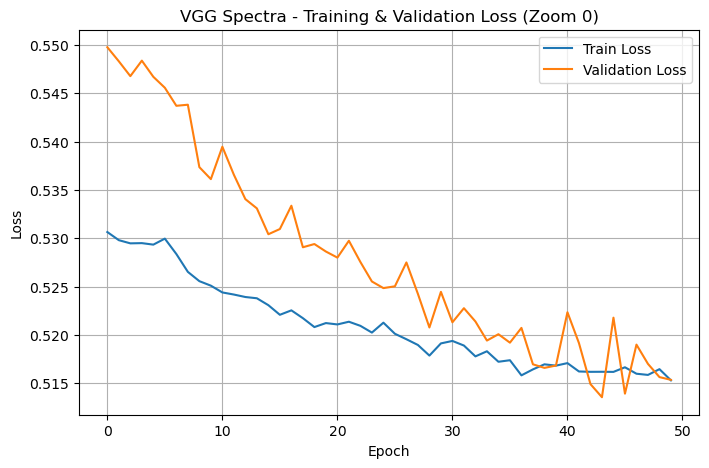

In [19]:
start = time.time()
if X_spec.ndim == 2:
    X_spec = X_spec.reshape(X_spec.shape[0], 1, 1, X_spec.shape[1])
elif X_spec.ndim == 3:
    X_spec = X_spec[:, None, :, :]
vgg_spec_score, vgg_spec_params, vgg_spec_mae, vgg_spec_r2, vgg_spec_nmad, vgg_spec_rmse, vgg_spec_model = run_skorch_grid_search_vgg(
    X_spec, Y, param_grid_vgg, X_spec.shape[1], X_spec.shape[2], X_spec.shape[3]
)
vgg_spec = {'r2': vgg_spec_r2, 'mae': vgg_spec_mae, 'nmad': vgg_spec_nmad, 'rmse': vgg_spec_rmse}
runtime["VGG Spectra"] = time.time() - start
print("VGG Spectra best params:", vgg_spec_params)
plot_history(vgg_spec_model, "VGG Spectra", 0)

### VGGNet12 Early Fusion:

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5308        0.5345  3.1984
      2        0.5281        0.5326  3.1820
      3        0.5234        0.5330  3.1795
      4        0.5250        0.5330  3.1963
      5        0.5239        0.5323  3.1859
      6        0.5235        0.5334  3.1828
      7        0.5244        0.5325  3.1820
      8        0.5240        0.5323  3.1854
      9        0.5240        0.5323  3.1820
     10        0.5241        0.5323  3.1942
     11        0.5234        0.5325  3.1836
     12        0.5242        0.5322  3.1855
     13        0.5238        0.5323  3.1854
     14        0.5237        0.5322  3.1864
     15        0.5239        0.5325  3.1921
     16        0.5236        0.5322  3.1930
     17        0.5243        0.5322  3.1875
     18        0.5238        0.5322  3.1858
     19        0.5232        0.5323  3.1805
     20        0.5234        0.5323  3.1853
     21        0.5232        0.5

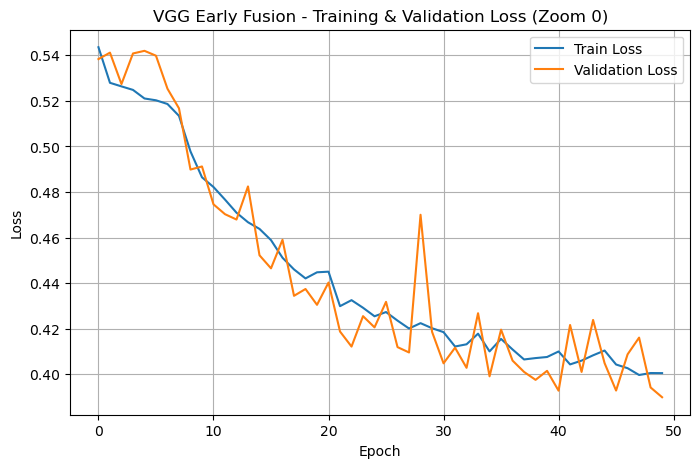

In [20]:
target_size = (X_photo.shape[2], X_photo.shape[3])
X_spec_tensor = torch.from_numpy(X_spec).float()
X_spec_tensor = F.interpolate(X_spec_tensor, size=target_size, mode='bilinear', align_corners=False)
X_spec = X_spec_tensor.numpy()
X_early_vgg = np.concatenate([X_photo, X_spec], axis=1)  # concatenate along channel axis
input_channels_early = X_photo.shape[1] + X_spec.shape[1]
start = time.time()
vgg_early_score, vgg_early_params, vgg_early_mae, vgg_early_r2, vgg_early_nmad, vgg_early_rmse, vgg_early_model = run_skorch_grid_search_vgg(
    X_early_vgg, Y, param_grid_vgg, input_channels_early, X_photo.shape[2], X_photo.shape[3]
)
vgg_early = {'r2': vgg_early_r2, 'mae': vgg_early_mae, 'nmad': vgg_early_nmad, 'rmse': vgg_early_rmse}
runtime["VGG Early Fusion"] = time.time() - start
print("VGG Early Fusion best params:", vgg_early_params)
plot_history(vgg_early_model, "VGG Early Fusion", 0)

### VGGNet12 Late Fusion:

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5244        0.5324  3.1406
      2        0.5241        0.5343  3.1221
      3        0.5240        0.5323  3.1229
      4        0.5240        0.5323  3.1275
      5        0.5238        0.5323  3.1252
      6        0.5230        0.5333  3.1365
      7        0.5242        0.5323  3.1262
      8        0.5233        0.5322  3.1254
      9        0.5233        0.5325  3.1273
     10        0.5238        0.5324  3.1261
     11        0.5233        0.5324  3.1263
     12        0.5240        0.5322  3.1359
     13        0.5234        0.5322  3.1113
     14        0.5236        0.5324  3.1268
     15        0.5239        0.5322  3.1264
     16        0.5237        0.5324  3.1264
     17        0.5236        0.5323  3.1260
Stopping since valid_loss has not improved in the last 10 epochs.
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1   

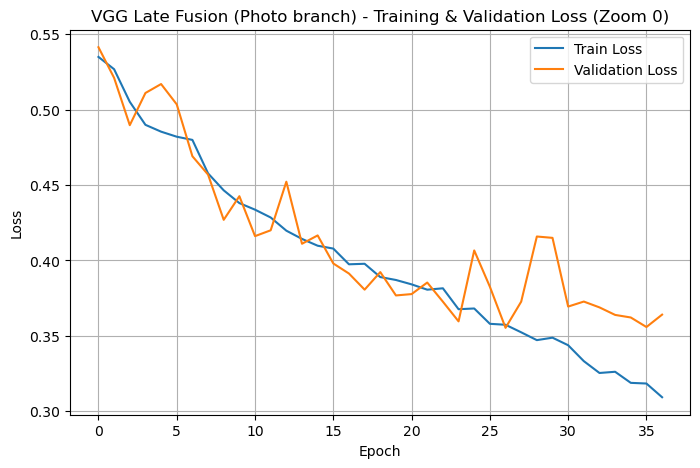

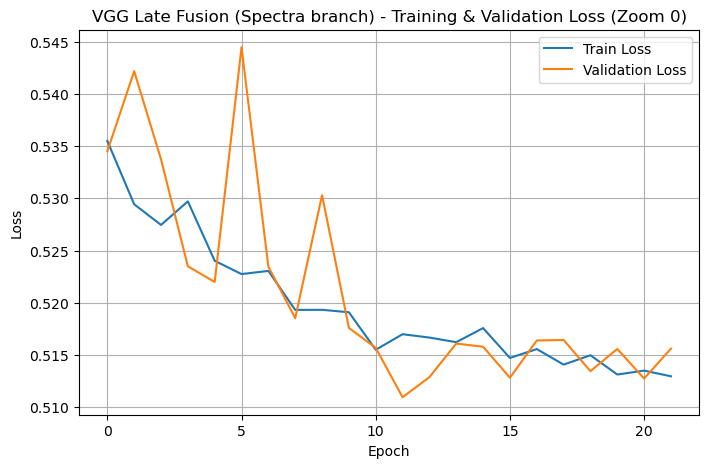

In [21]:
start = time.time()
vgg_photo_model_late = run_skorch_grid_search_vgg(X_photo, Y, param_grid_vgg, X_photo.shape[1], X_photo.shape[2], X_photo.shape[3])[6]
vgg_spec_model_late = run_skorch_grid_search_vgg(X_spec, Y, param_grid_vgg, X_spec.shape[1], X_spec.shape[2], X_spec.shape[3])[6]
Y_pred_vgg_photo = vgg_photo_model_late.predict(X_photo)
Y_pred_vgg_spec = vgg_spec_model_late.predict(X_spec)
Y_pred_vgg_late = (Y_pred_vgg_photo + Y_pred_vgg_spec) / 2.0
vgg_late_mae = mean_absolute_error(Y, Y_pred_vgg_late)
vgg_late_r2 = r2_score(Y, Y_pred_vgg_late)
vgg_late_nmad = 1.4826 * np.median(np.abs(Y_pred_vgg_late - Y - np.median(Y_pred_vgg_late - Y)))
vgg_late_rmse = np.sqrt(mean_squared_error(Y, Y_pred_vgg_late))
vgg_late = {'r2': vgg_late_r2, 'mae': vgg_late_mae, 'nmad': vgg_late_nmad, 'rmse': vgg_late_rmse}
runtime["VGG Late Fusion"] = time.time() - start
vgg_photo_params_late = run_skorch_grid_search_vgg(X_photo, Y, param_grid_vgg, X_photo.shape[1], X_photo.shape[2], X_photo.shape[3])[1]
vgg_spec_params_late = run_skorch_grid_search_vgg(X_spec, Y, param_grid_vgg, X_spec.shape[1], X_spec.shape[2], X_spec.shape[3])[1]
print("VGG Late Fusion - Photo best params:", vgg_photo_params_late)
print("VGG Late Fusion - Spectra best params:", vgg_spec_params_late)
# For late fusion, you may also plot history for one of the models
plot_history(vgg_photo_model_late, "VGG Late Fusion (Photo branch)", 0)
plot_history(vgg_spec_model_late, "VGG Late Fusion (Spectra branch)", 0)

### Compile all results:

In [22]:
comparison_vgg = {
    "VGG Photo": vgg_photo,
    "VGG Spectra": vgg_spec,
    "VGG Early Fusion": vgg_early,
    "VGG Late Fusion": vgg_late
}

for method, met in comparison_vgg.items():
    print(f"{method}: R² = {met['r2']:.3f}, MAE = {met['mae']:.3f}, NMAD = {met['nmad']:.3f}, RMSE = {met['rmse']:.3f}")

VGG Photo: R² = 0.285, MAE = 0.484, NMAD = 0.874, RMSE = 0.617
VGG Spectra: R² = 0.035, MAE = 0.597, NMAD = 0.843, RMSE = 0.717
VGG Early Fusion: R² = 0.276, MAE = 0.488, NMAD = 0.872, RMSE = 0.621
VGG Late Fusion: R² = 0.361, MAE = 0.465, NMAD = 0.860, RMSE = 0.583


### Visualization of comparative metrics:

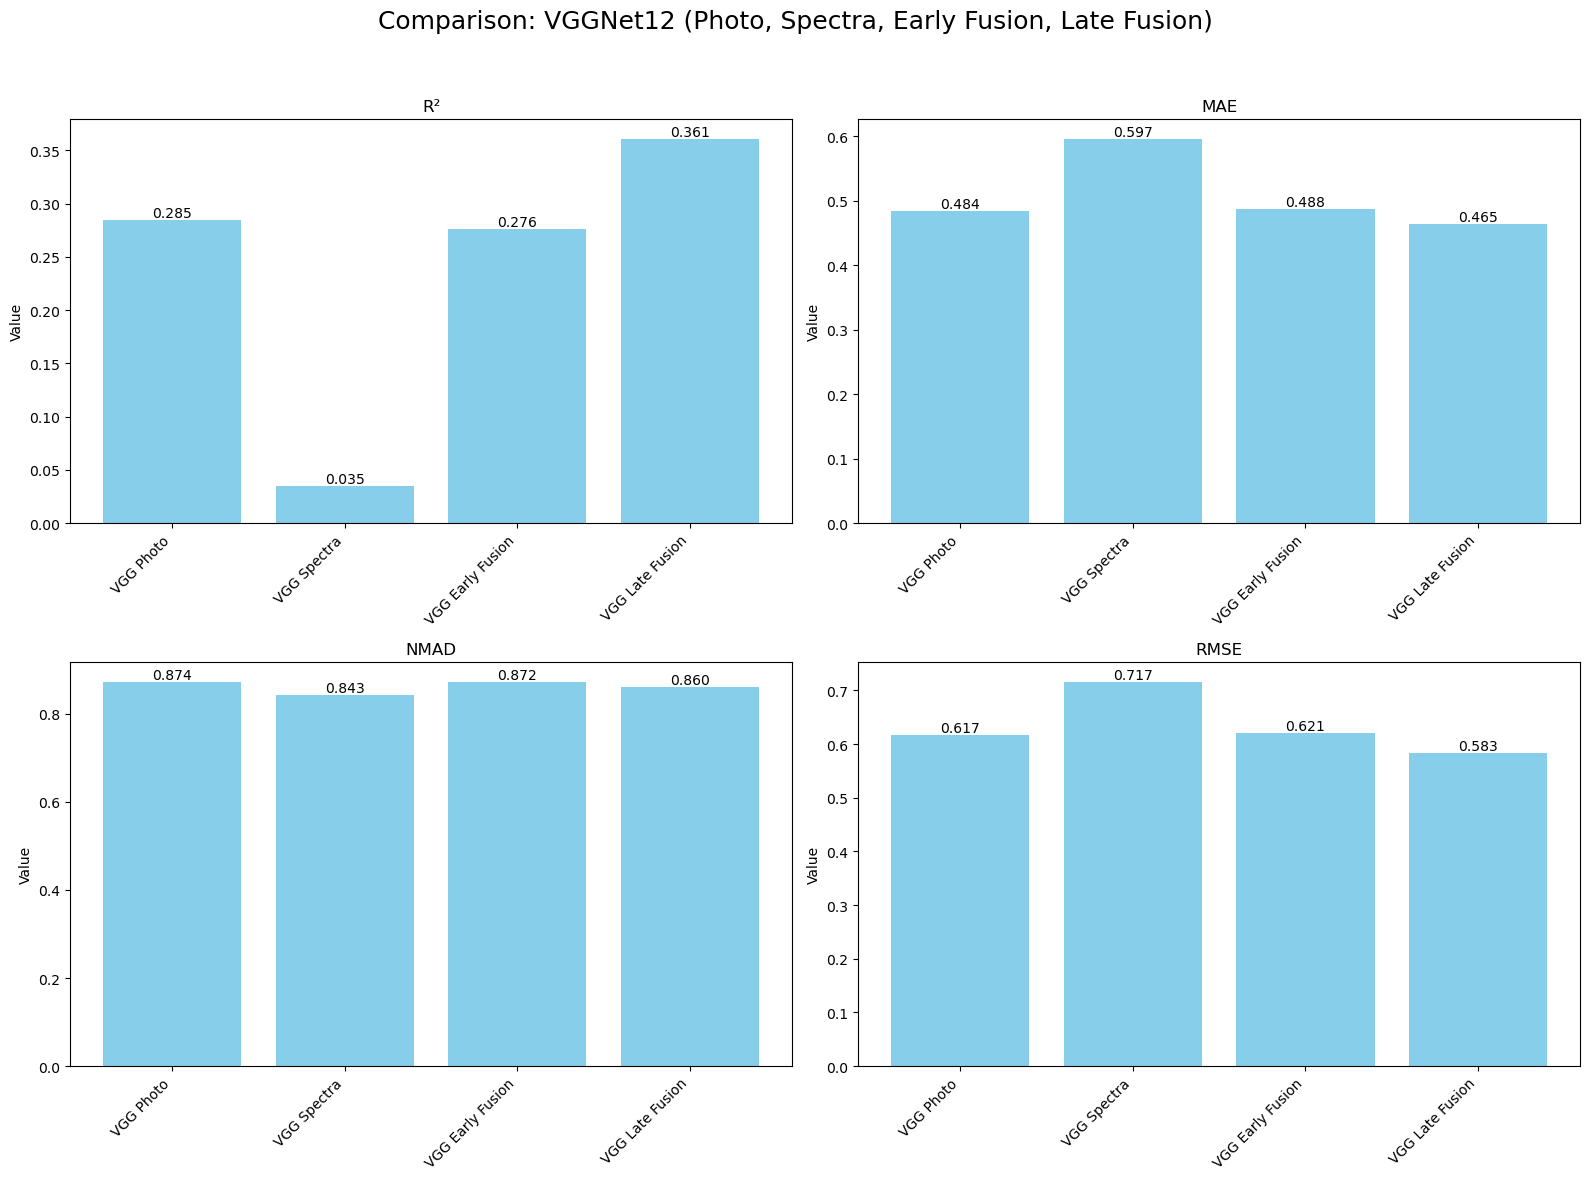

In [23]:
methods = list(comparison_vgg.keys())
metrics_names = ['R²', 'MAE', 'NMAD', 'RMSE']
values = {metric: [] for metric in metrics_names}
for method in methods:
    values['R²'].append(comparison_vgg[method]['r2'])
    values['MAE'].append(comparison_vgg[method]['mae'])
    values['NMAD'].append(comparison_vgg[method]['nmad'])
    values['RMSE'].append(comparison_vgg[method]['rmse'])

x = np.arange(len(methods))
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
axs = axs.flatten()
for i, metric in enumerate(metrics_names):
    axs[i].bar(x, values[metric], color='skyblue')
    axs[i].set_xticks(x)
    axs[i].set_xticklabels(methods, rotation=45, ha='right')
    axs[i].set_title(metric)
    axs[i].set_ylabel("Value")
    for j, v in enumerate(values[metric]):
        axs[i].text(j, v, f"{v:.3f}", ha='center', va='bottom', fontsize=10)
plt.suptitle("Comparison: VGGNet12 (Photo, Spectra, Early Fusion, Late Fusion)", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Visualization of runtimes:

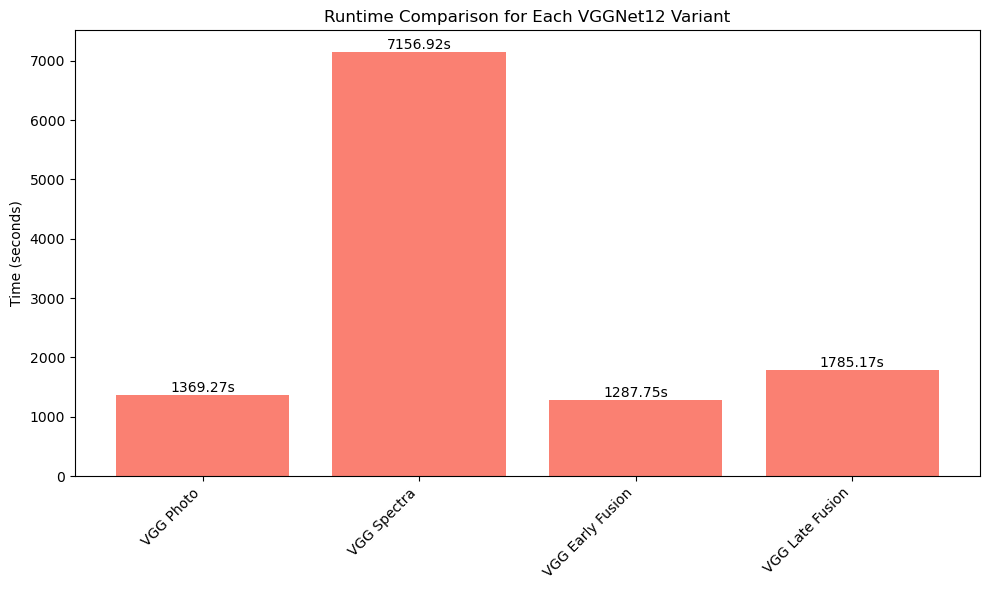

In [24]:
runtime_methods = list(runtime.keys())
runtime_values = [runtime[m] for m in runtime_methods]

plt.figure(figsize=(10, 6))
plt.bar(runtime_methods, runtime_values, color='salmon')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Time (seconds)")
plt.title("Runtime Comparison for Each VGGNet12 Variant")
for i, t in enumerate(runtime_values):
    plt.text(i, t, f"{t:.2f}s", ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()